In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Qobj, basis, mesolve)

%matplotlib inline

In [40]:
delta = 0
omega0 = 100*np.pi
tf = 1
num_points = 1000
a0 = 40
num_qubits = 7

times = np.linspace(0, tf, num_points)

In [41]:
def pulses(times, tf, a0):
    num_deriv = 2

    step = times[1] - times[0]
    t = np.linspace(0, times[-1] + step*num_deriv , len(times) + num_deriv)

    chi = np.pi*t/(2*tf) - np.sin(2*np.pi*t/tf)/3 + np.sin(4*np.pi*t/tf)/24
    chid = np.diff(chi)/np.diff(t)
    eta = np.arctan(chid/a0)
    etad = np.diff(eta)/np.diff(t[:-1])

    omega23 = (chid[:-1]/np.tan(eta[:-1]) - etad*np.tan(chi[:-2]))/(np.sin(chi[:-2])*np.tan(chi[:-2]) + np.cos(chi[:-2]))
    omega12 = (etad + omega23*np.sin(chi[:-2]))/np.cos(chi[:-2])
    return omega12, omega23

In [42]:
def omegas_g(t, tf, sigma, omegas0):
    return omegas0 * np.exp(-(t - tf/2)**2 / (2*sigma**2))

In [43]:
def solvePopulations(times, pulse1, pulse2, pulses, num_qubits):
    psi0 = basis(num_qubits, 0)

    if len(times) < 2:
        return np.abs(np.array([psi0])) ** 2
    
    base_matrix = np.zeros((num_qubits, num_qubits))

    h0_matrix = base_matrix.copy()
    h0_matrix[int(num_qubits/2), int(num_qubits/2)] = delta
    H0 = Qobj(h0_matrix)

    h12_matrix = base_matrix.copy()
    h12_matrix[0, 1] = -1
    h12_matrix[1, 0] = -1
    H12 = Qobj(h12_matrix)

    h23_matrix = base_matrix.copy()
    h23_matrix[-2, -1] = -1
    h23_matrix[-1, -2] = -1
    H23 = Qobj(h23_matrix)

    hs_matrix = base_matrix.copy()
    for i in range(num_qubits - 3):
            hs_matrix[i + 1, i + 2] = -1
            hs_matrix[i + 2, i + 1] = -1
    HS = Qobj(hs_matrix)

    H = [H0, [H12, pulse1], [H23, pulse2], [HS, pulses]]

    result = mesolve(H, psi0, times)

    psi_t = np.array(result.states).reshape((len(times), num_qubits))
    return np.abs(psi_t) ** 2

In [47]:
omega12, omega23,  = pulses(times, tf, a0)
n = (num_qubits - 1)/2

omega1p = np.sqrt(n)*omega12
omega2p = np.sqrt(n)*omega23
omegasp = 20*omega0*omegas_g(times, tf, tf/6, tf/6)

population = solvePopulations(times, omega1p, omega2p, omegasp, num_qubits)

Text(0, 0.5, 'pulse')

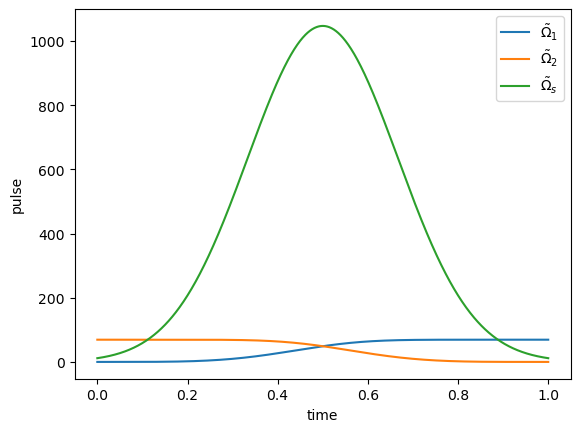

In [48]:
fig, ax = plt.subplots()

ax.plot(times, omega1p, label=r'$\tilde{\Omega}_1$')
ax.plot(times, omega2p, label=r'$\tilde{\Omega}_2$')
ax.plot(times, omegasp, label=r'$\tilde{\Omega}_s$')

ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('pulse')

Text(0, 0.5, 'P')

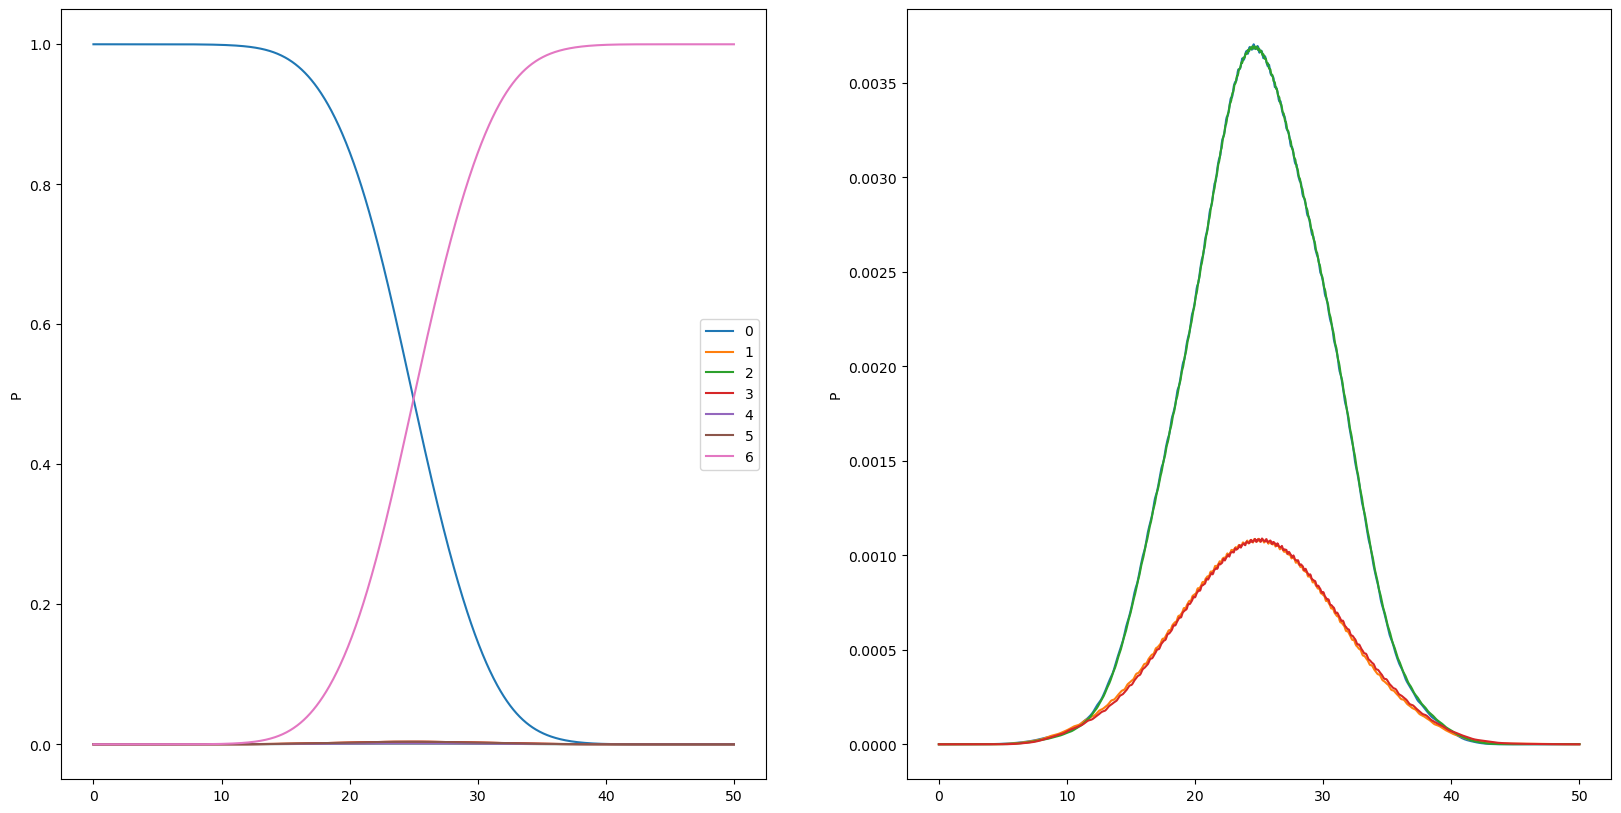

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

# ax[0].plot(times*omega0/(2*np.pi), population)
for i, pop in enumerate(population.T):
    ax[0].plot(times * omega0 / (2 * np.pi), pop, label=f'{i}')

ax[0].set_ylabel("P")
ax[0].legend()

ax[1].plot(times*omega0/(2*np.pi), population[:,1:-2])
ax[1].set_ylabel("P")